# Calculate heatwave occurrances 

## NEW heatwave definition 2021

Heatwaves are now defined as:

Tmin > 95percentile AND Tmax > 95percentile

For more than 2 consecutive days (i.e. total of 3 or more days).

This replaces the definition of only Tmin > 99percentile for more than 3 consecutive days (total of 4 or more days).

This is what is requested from the Lancet. To be honest it's not clear whether this produces a substantially 'better' indicator since all heatwave indicators are arbitrary in absence of covariate data (i.e. impact data). Furthermore we know that the health impacts are mediated by many other things, so in any case we are truely interested just in the trends i.e. demonstrating that there is a) more heatwaves and b) more exposure to heatwaves - this can be followed by local studies but (as always) the point is to present a general risk factor trend.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats

from tqdm.notebook import tqdm, tnrange
from dask.diagnostics import ProgressBar
from joblib import Parallel, delayed

from config import DATA_SRC, WEATHER_SRC

import heatwave_indices


xr.set_options(keep_attrs=True)

# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
MAP_PROJECTION = ccrs.EckertIII()

In [3]:
# import hvplot.xarray # noqa
# import panel.widgets as pnw

### Setup Paths

> NOTE: considered just adding the newest year each time instead of re-calculating the whole thing. HOWEVER in reality, the input data is still changing year to year, so far have needed to re-calculate anyway (e.g. change in resolution, change from ERAI to ERA5, in the future probably use ERA5-Land, etc). Although it seems like a cool idea to have a reproducible method where each year you just add one thing, in practice its better to have one 'frozen' output corresponding to each publication, so that it's easy to go back later to find data corresponding to specific results. Additionally, generating one file per year means you have a folder full of files that are harder to share, and the outputs are in the end pretty small (<50MB in Float32)}.

In [4]:
MAX_YEAR = 2020

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

TEMPERATURES_FOLDER = WEATHER_SRC / 'era5_0.25deg' / 'daily_temperature_summary'
CLIMATOLOGY_QUANTILES = WEATHER_SRC / 'era5_0.25deg' / 'daily_tas_quantiles_1986-2005.nc'

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()
RESULTS_FOLDER.mkdir(exist_ok=True)

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2021'
INTERMEDIATE_RESULTS_FOLDER.mkdir(exist_ok=True)


In [5]:
assert INTERMEDIATE_RESULTS_FOLDER.is_dir()
assert RESULTS_FOLDER.is_dir()

In [6]:
temperature_files= [(year, TEMPERATURES_FOLDER / f'{year}_temperature_summary.nc') for year in range(1980, MAX_YEAR+1)]

## Load ERA5 reference temperature quantiles

Load both the tmin and tmax quatiles and place in a list

In [7]:
QUANTILE = 0.95

t_quantiles = xr.open_dataset(CLIMATOLOGY_QUANTILES)
# Need to use tolerance/nearest b/c of floating point drift (0.95 != 0.95)
t_min_threshold = t_quantiles.t_min.sel(quantile=QUANTILE, drop=True, tolerance=0.001, method='nearest')
t_max_threshold = t_quantiles.t_max.sel(quantile=QUANTILE, drop=True, tolerance=0.001, method='nearest')

t_thresholds = [t_min_threshold, t_max_threshold]

In [8]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(t_min_threshold.latitude))

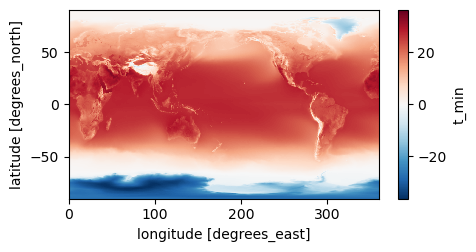

In [9]:
(t_min_threshold -273).plot()

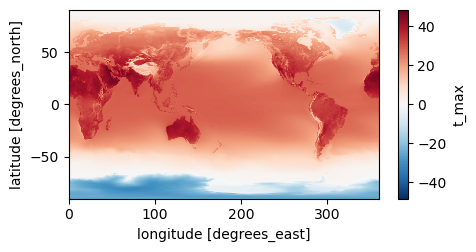

In [10]:
(t_max_threshold -273).plot()

# Define calculation functions for counting heatwave occurances

Apply heatwave index function to selected vars using selected threshold days

In [15]:
def apply_func_for_file(func, year, year_file, t_thresholds, t_var_names=['t_min', 't_max'], days_threshold=2):
    ds = xr.open_dataset(year_file)
    ds = ds.transpose('time','latitude','longitude')
    
    datasets_year = [ds[name] for name in t_var_names]
    result = func(datasets_year, t_thresholds, days_threshold)
    
    # Add a year dimension matching the input file
    result = result.expand_dims(dim={'year': [year]})
    return year, result

# Create and save in one go (for now saving a single output file since it's not that big)
def apply_func_and_save(func, year, year_file, output_file, t_thresholds,  t_var_names=['t_min', 't_max'], days_threshold=2, overwrite=False):
    if output_file.exists() is False and overwrite is False:
        year, result = apply_func_for_file(func, year_file, t_thresholds, t_var_names=t_var_names, days_threshold=days_threshold)
        result.to_netcdf(output_file)
        return f'Created {output_file}'
    else:
        return f'Skipped {output_file}, already exists'

# Calculate heatwave occurances


## Multi-threshold versions

New in 2021

### Heatwave Counts

In [12]:
from importlib import reload
reload(heatwave_indices)

<module 'heatwave_indices' from '/home/jonathanchambers/Documents/Lancet/2021 material/notebooks/heatwave_indices.py'>

In [16]:
heatwaves_counts = Parallel(n_jobs=8, verbose=2)(
    delayed(apply_func_for_file)(heatwave_indices.heatwaves_counts_multi_threshold, year, file, t_thresholds)
    for year, file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
heatwaves_counts = [item[1] for item in sorted(heatwaves_counts, key=lambda i: i[0])]
heatwaves_counts = xr.concat(heatwaves_counts, dim='year')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   41.2s
[Parallel(n_jobs=8)]: Done  41 out of  41 | elapsed:   58.4s finished


In [17]:
(heatwaves_counts
 .to_dataset(name='heatwaves_counts')
 .to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_counts_multi_threshold_1980-{MAX_YEAR}.nc', 
            encoding={'heatwaves_counts':{'dtype':'int16'}}))

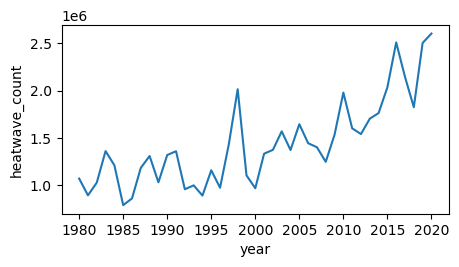

In [18]:
heatwaves_counts.sum(dim=['latitude', 'longitude']).plot()

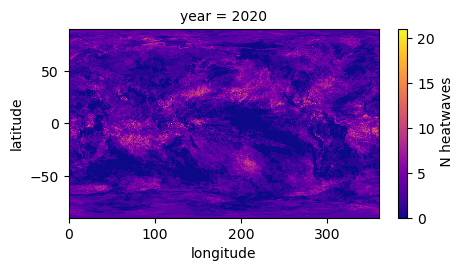

In [20]:
data = heatwaves_counts.sel(year=MAX_YEAR)

p = data.plot.pcolormesh(
    cmap='plasma',
    cbar_kwargs={
                 'label':' N heatwaves'},
    robust=False
)

# ax.set(title=f'Number of heatwaves in {MAX_YEAR}')

In [21]:
# heatwaves_counts.interactive.sel(year=pnw.DiscreteSlider).plot()

### Heatwave number of days

In [22]:
heatwaves_days = Parallel(n_jobs=8, verbose=2)(
    delayed(apply_func_for_file)(heatwave_indices.heatwaves_days_multi_threshold, year, file, t_thresholds)
    for year, file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
heatwaves_days = [item[1] for item in sorted(heatwaves_days, key=lambda i: i[0])]
heatwaves_days = xr.concat(heatwaves_days, dim='year')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   41.0s
[Parallel(n_jobs=8)]: Done  41 out of  41 | elapsed:   58.4s finished


In [23]:
(heatwaves_days
 .to_dataset(name='heatwaves_days')
 .to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_days_multi_threshold_1980-{MAX_YEAR}.nc',
            encoding={'heatwaves_days':{'dtype':'int16'}}))

In [24]:
# heatwaves_days.interactive.sel(year=pnw.DiscreteSlider).plot()

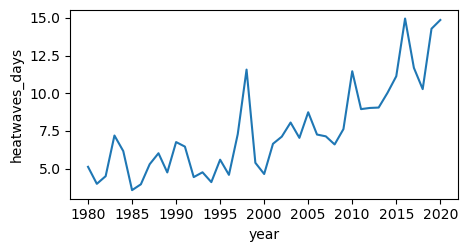

In [25]:
heatwaves_days.mean(dim=['latitude', 'longitude']).plot()

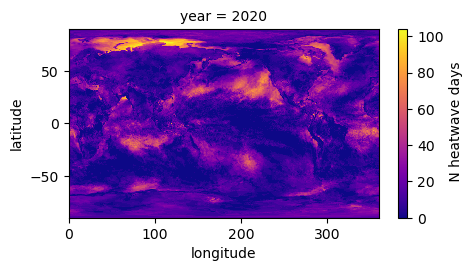

In [27]:
data = heatwaves_days.sel(year=MAX_YEAR)

p = data.plot.pcolormesh(
    cmap='plasma',
    cbar_kwargs={'label':' N heatwave days'},
    robust=False
)

# ax.set(title=f'Number of heatwave dayss in {MAX_YEAR}')

### Heatwave length

This is more accurate to call 'length' than what has been referred to as HW length so far - its tracking on average per heatwave and year how long each heatwave is. This is much better combined with replacement of heatwave N events with heatwave N days. Since the N events could be misleading if you have one long heatwave, better to calculate the total number of days and the total number of days per heatwave, to answer the questions "Are there more heatwaves overall?" and "Are heatwaves getting longer?"

In [28]:
heatwave_mean_length = heatwaves_days / heatwaves_counts

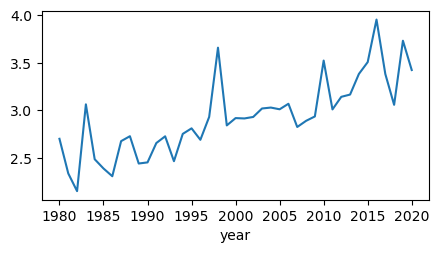

In [29]:
(heatwave_mean_length*cos_lat).mean(dim=['latitude', 'longitude']).plot()

In [30]:
(heatwave_mean_length.to_dataset(name='heatwave_mean_length')
 .to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_mean_length_multi_threshold_1980-{MAX_YEAR}.nc',
            encoding={'heatwave_mean_length':{'dtype':'float32'}}))

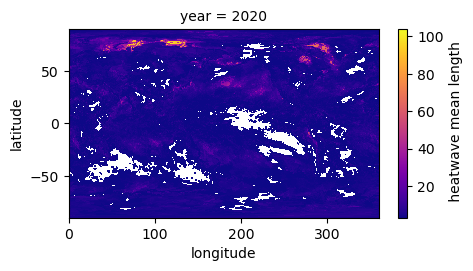

In [31]:
data = heatwave_mean_length.sel(year=MAX_YEAR)

p = data.plot.pcolormesh(
    cmap='plasma',
    cbar_kwargs={'label':' heatwave mean length'},
    robust=False
)


## Single threshold versions (method from before 2020) but using 2day minimum

In [32]:
def apply_func_for_file_OLD(func, year, year_file, t_thresholds, t_var_names='t_min', days_threshold=2):
    ds = xr.open_dataset(year_file)
    ds = ds.transpose('time','latitude','longitude')
    datasets_year = ds[t_var_names]
    
    result = func(datasets_year, t_thresholds, days_threshold)
    
    # Add a year dimension matching the input file
    result = result.expand_dims(dim={'year': [year]})
    return year, result

In [33]:
QUANTILE_OLD = 0.99

# Need to use tolerance/nearest b/c of floating point drift (0.95 != 0.95)
t_min_threshold = t_quantiles.t_min.sel(quantile=QUANTILE_OLD, drop=True, tolerance=0.001, method='nearest')

### Heatwave Counts - Single Threshold

In [34]:
heatwaves_counts_OLD = Parallel(n_jobs=8, verbose=2)(
    delayed(apply_func_for_file_OLD)(heatwave_indices.heatwaves_counts_single_threshold, year, file, t_min_threshold) 
    for year, file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
heatwaves_counts_OLD = [item[1] for item in sorted(heatwaves_counts_OLD, key=lambda i: i[0])]
heatwaves_counts_OLD = xr.concat(heatwaves_counts_OLD, dim='year')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   22.3s
[Parallel(n_jobs=8)]: Done  41 out of  41 | elapsed:   31.9s finished


In [35]:
(heatwaves_counts_OLD
 .to_dataset(name='heatwaves_counts')
 .to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_counts_single_threshold_1980-{MAX_YEAR}.nc',
            encoding={'heatwaves_counts':{'dtype':'int16'}}))

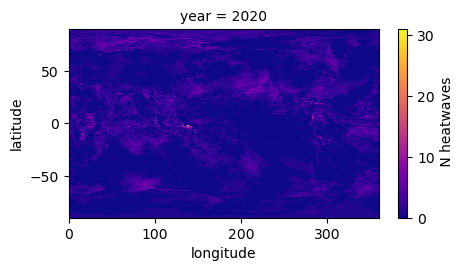

In [37]:
data = heatwaves_counts_OLD.sel(year=MAX_YEAR)

p = data.plot.pcolormesh(
    cmap='plasma',
    cbar_kwargs={
                 'label':' N heatwaves'},
    robust=False
)

# ax.set(title=f'Number of heatwaves in {MAX_YEAR}')

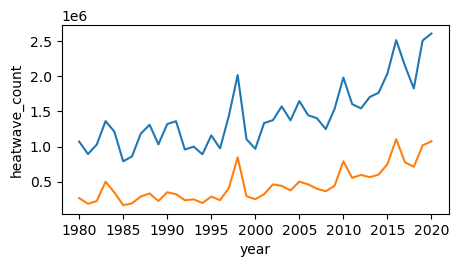

In [40]:
heatwaves_counts.sum(dim=['latitude', 'longitude']).plot()
heatwaves_counts_OLD.sum(dim=['latitude', 'longitude']).plot()

In [ ]:
# heatwaves_counts.interactive.sel(year=pnw.DiscreteSlider).plot()

### Heatwave number of days

In [42]:
heatwaves_days_OLD = Parallel(n_jobs=8, verbose=2)(
    delayed(apply_func_for_file_OLD)(heatwave_indices.heatwaves_days_single_threshold, year, file, t_min_threshold)
    for year, file in  temperature_files
)
# Use the year returned from the parallel func to sort the outputs before concat
heatwaves_days_OLD = [item[1] for item in sorted(heatwaves_days_OLD, key=lambda i: i[0])]
heatwaves_days_OLD = xr.concat(heatwaves_days_OLD, dim='year')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done  41 out of  41 | elapsed:   33.7s finished


In [43]:
(heatwaves_days_OLD
 .to_dataset(name='heatwaves_days')
 .to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwaves_days_single_threshold_1980-{MAX_YEAR}.nc',
            encoding={'heatwaves_days':{'dtype':'int16'}}))

In [44]:
# heatwaves_days.interactive.sel(year=pnw.DiscreteSlider).plot()

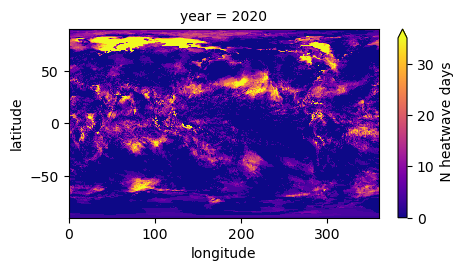

In [45]:
data = heatwaves_days_OLD.sel(year=MAX_YEAR)

p = data.plot.pcolormesh(
    cmap='plasma',
    cbar_kwargs={'label':' N heatwave days'},
    robust=True
)

# ax.set(title=f'Number of heatwave days in {MAX_YEAR}')

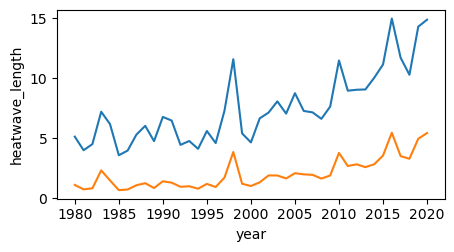

In [46]:
heatwaves_days.mean(dim=['latitude', 'longitude']).plot()
heatwaves_days_OLD.mean(dim=['latitude', 'longitude']).plot()